# Week 9 - Combining Models

Learning contents:
- Base Classifier
    - Train a Least Squares classifier, perform a prediction on the samples, and compute the accuracy
    - Plot the decision boundary for least squares classifier
- Committees
    - Split the training data into M=9 equally sized, non-overlapping parts
    - Train M=9 Least Squares classifiers, one for each data split
    - Perform predictions on the whole dataset using a comitteee of classifiers and compute the accuracy
    - Plot the decision boundary for committee classifier
- Decision tree
    - Fit a DecisionTreeClassifier using scikit-learn, perform a prediction on the data, and compute the accuracy
    - Plot the decision boundary for the DecisionTreeClassifier
- AdaBoost
    - Create an AdaBoost classifier of DecisionTreeClassifiers using the scikit-learn library
    - Plot the decision boundary for the AdaBoostClassifier


In [26]:
# Dependencies
import numpy as np
import scipy
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set(); sns.set_palette('bright')

In [27]:
# Some plotting functions, we'll be using later


def plot_scatter(data, target, alpha=0.5, legend=True):
    scatter = plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=alpha, cmap='rainbow')
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
def plot_mesh(X, pred_fn, n_class=2):
    plt_margin = 5
    x_min, x_max = min(X[:,0]) - plt_margin, max(X[:,0]) + plt_margin
    y_min, y_max = min(X[:,1]) - plt_margin, max(X[:,1]) + plt_margin
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_fn(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))

# Dataset
We'll be working with a slightly modified version of the digits data

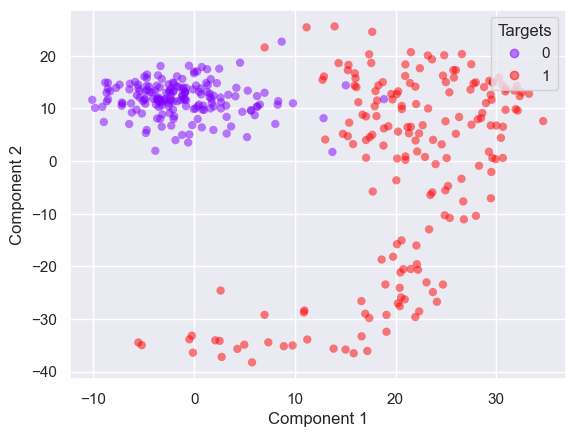

In [28]:
digits = load_digits(n_class=2)

# Get a 2D version of the data using PCA
pca = PCA(n_components=2)
t = digits.target
X = pca.fit_transform(digits.data)

# In order to get a non-linearly seperable case, 
# we'll modify the data a bit this time, 
# translating the '-1' class to the right and up
X = np.where(
    np.repeat(np.expand_dims(t == 1, axis=1), 2, axis=1), 
    X, 
    np.vstack([X[:,0]+20, X[:,1]+10]).T
)

N = len(t) # total number of samples

plot_scatter(X, t)

# 0) Base Classifier

## 0.1) Train a Least Squares classifier, perform a prediction on the samples, and compute the accuracy
Use your solution from the exercise "Week 7 - Linear classification" section 1.1 and 1.2. The accuracy is to be calculated in terms of the proportion of correct predictions compared to the number of predictions and should print a single float.

In [29]:
def least_squares_classification(X, t):
    # Create PHI matrix (bias + features)
    N = X.shape[0]
    ones = np.ones((N, 1))
    PHI = np.hstack([ones, X])

    W = np.linalg.pinv(PHI) @ t.reshape(-1, 1)

    return W.reshape(-1, 1)

# Find optimal weights using least squares
W_least_squares = least_squares_classification(X, t)
W_least_squares

def predict(W, X, decision_boundary=0.5):
    
    # Create PHI matrix
    N = X.shape[0]
    ones = np.ones((N, 1))
    PHI = np.hstack([ones, X]) 
    
    #  y = PHI * W
    y = PHI @ W
    
    predictions = (y.flatten() >= decision_boundary).astype(int)
    
    return predictions

# Make predictions using least squares weights
predictions_ls = predict(W_least_squares, X, decision_boundary=0.5)

# Calculate accuracy
accuracy = np.mean(predictions_ls == t)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9694444444444444


## 0.2) Plot the decision boundary for least squares classifier
Hint: you can do this by either plotting a line on the boundary or creating a mesh of all predictions (similar to section 1.3 in "week 7 - Linear classification"). You can of course use the helper functions (plot_scatter() and plot_mesh()) given at the start of this file. 

/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_84356/593679599.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


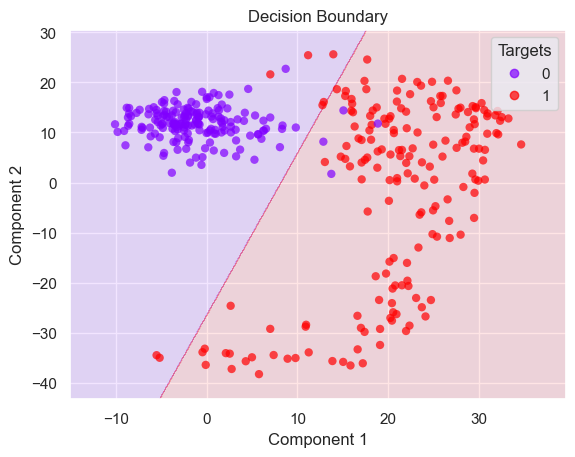

In [30]:
# Create a prediction function for the mesh plot
def predict_fn(X_new):
    return predict(W_least_squares, X_new, decision_boundary=0.5)

# Plot decision boundary using mesh
plot_mesh(X, predict_fn, n_class=2)
plot_scatter(X, t, alpha=0.7)
plt.title('Decision Boundary')
plt.show()

# 1) Committees

## 1.1) Split the training data into M=9 equally sized, non-overlapping parts
Hint: use the numpy.split() command.

In [31]:
M = 9

X_splits = np.split(X, M)
t_splits = np.split(t, M)

## 1.2) Train M=9 Least Squares classifiers, one for each (9) data split using the same method as in section 0.1
Hint: loop over the training data containing of the X split and t split zipped together using the zip() command.

In [32]:
pairs = []

for X_split, t_split in zip(X_splits, t_splits):
    W = least_squares_classification(X_split, t_split)
    pairs.append(W)

## 1.3) Perform a prediction on the whole dataset using committee of classifiers (lecture 17 slide 4) and compute the accuracy 

In [33]:
committee_predictions_list = []

for W in pairs:
    preds = predict(W, X, decision_boundary=0.5)
    committee_predictions_list.append(preds)

committee_predictions_array = np.array(committee_predictions_list)
committee_output = np.mean(committee_predictions_array, axis=0)

predictions_committee = (committee_output >= 0.5).astype(int)

accuracy_committee = np.mean(predictions_committee == t)
print(f"Accuracy: {accuracy_committee}")

Accuracy: 0.9583333333333334


## 1.4 Plot the decision boundary for committee classifier

/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_84356/593679599.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


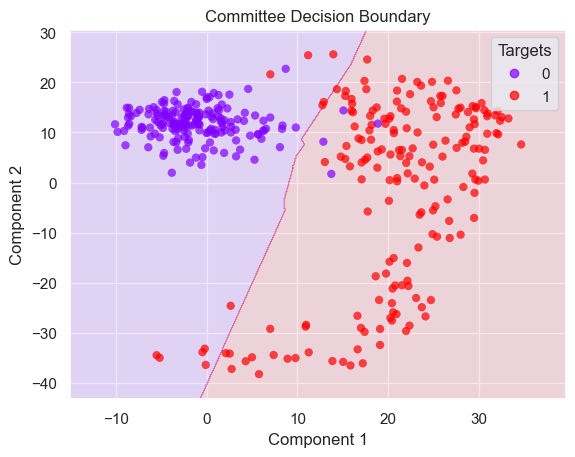

In [34]:
def predict_committee_fn(X_new):
    committee_preds = []
    for W in pairs:
        preds = predict(W, X_new, decision_boundary=0.5)
        committee_preds.append(preds)
    
    committee_avg = np.mean(np.array(committee_preds), axis=0)
    return (committee_avg >= 0.5).astype(int)

plot_mesh(X, predict_committee_fn, n_class=2)
plot_scatter(X, t, alpha=0.7)
plt.title('Committee Decision Boundary')
plt.show()

# 2) Tree

## 2.1) Fit a DecisionTreeClassifier imported from the `scikit-learn` library, perform a prediction on the data, and compute the accuracy
Use `max_depth=3`. You will use fit() and predict() methods of the DecisionTreeClassifier class in order to respectively train and predict from your classifier

In [35]:
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(max_depth=3)
tree_classifier.fit(X, t)

predictions_tree = tree_classifier.predict(X)

accuracy_tree = np.mean(predictions_tree == t)
print(f"Accuracy: {accuracy_tree}")

Accuracy: 0.9861111111111112


## 2.2) Plot the decision boundary for the DecisionTreeClassifier

/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_84356/593679599.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


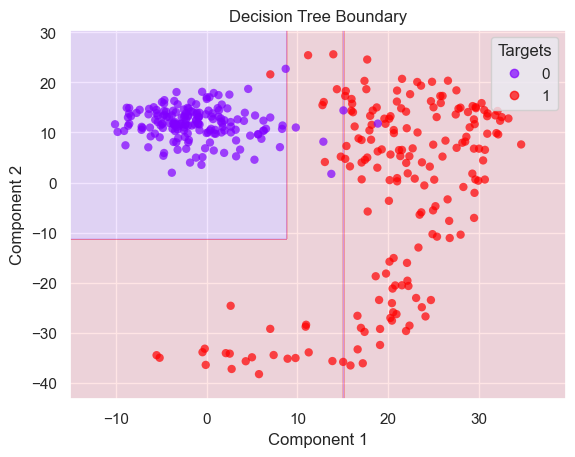

In [36]:
def predict_tree_fn(X_new):
    return tree_classifier.predict(X_new)

plot_mesh(X, predict_tree_fn, n_class=2)
plot_scatter(X, t, alpha=0.7)
plt.title('Decision Tree Boundary')
plt.show()


# 3) AdaBoost

## 3.1) Create an AdaBoost classifier of DecisionTreeClassifiers using the `scikit-learn` library, and compute the accuracy
Use a depth of 1 for the `DecisionTreeClassifier` and 7 estimators for the `AdaBoostClassifier`. Use the defaults for the other parameters

In [37]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=1)

adaboost_classifier = AdaBoostClassifier(n_estimators=7)

adaboost_classifier.fit(X, t)

predictions_adaboost = adaboost_classifier.predict(X)

accuracy_adaboost = np.mean(predictions_adaboost == t)
print(f"Accuracy: {accuracy_adaboost}")


Accuracy: 0.9777777777777777


## 3.2) Plot the decision boundary for the AdaBoostClassifier

/var/folders/cz/mx5m39wn22b9z03lv1qtl7cm0000gn/T/ipykernel_84356/593679599.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


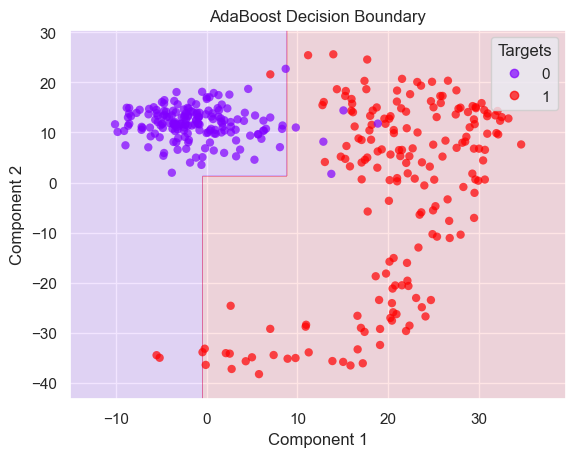

In [38]:
def predict_adaboost_fn(X_new):
    return adaboost_classifier.predict(X_new)

plot_mesh(X, predict_adaboost_fn, n_class=2)
plot_scatter(X, t, alpha=0.7)
plt.title('AdaBoost Decision Boundary')
plt.show()
